In [1]:
import os
import sys

sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from OGMM import OGMM, init_cov_and_T_split

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [3]:
dataset.shape

(2860, 18)

In [4]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1

In [5]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [80]:
proj = TSNE(n_components=2).fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)

In [18]:
names = [f'domain {i}' for i in range(7)]

In [19]:
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

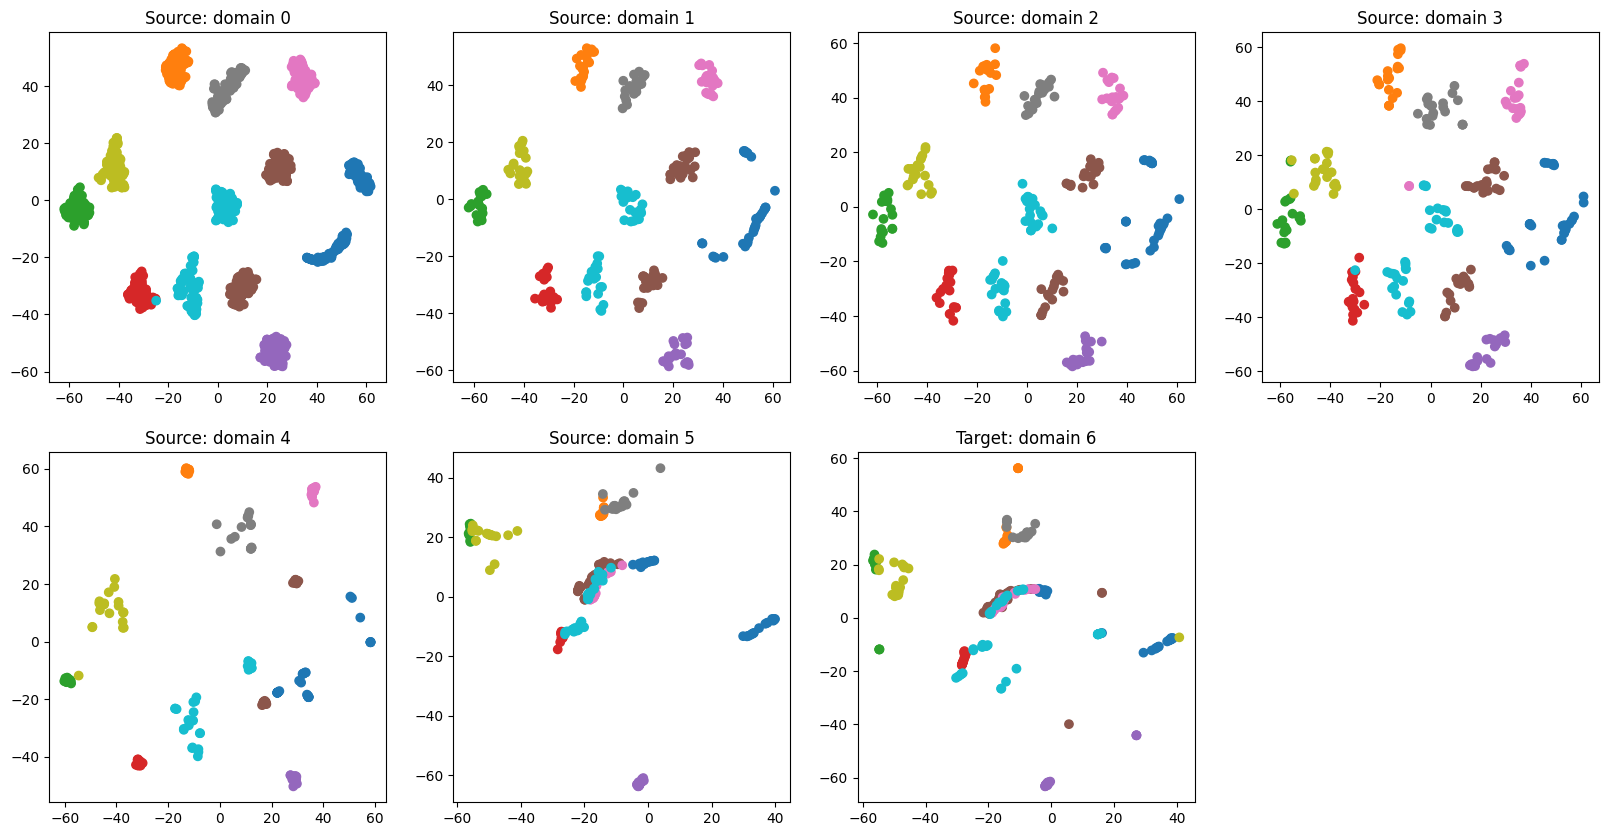

In [84]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

In [8]:
n_samples = 1300
batch_size = 260
n_components = 3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)

In [10]:
range_data = np.mean(np.max(X_train_target, axis=0) - np.min(X_train_target, axis=0))

K_max = 26
cov_init, T_split = init_cov_and_T_split(K_max, range_data, X_train_target.shape[1])
GMM_online = OGMM(X_train_target_t, K_max, cov_init, 0.1, T_split)

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\OGMM.py:55: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


In [11]:
GMM_online

[[tensor(0.2712),
  tensor(55.3246),
  tensor([0.0232, 0.0283, 0.0169, 0.0282, 0.0130, 0.1923, 0.0133, 0.1826, 0.0189,
          0.2090, 0.0263, 0.0280, 0.0166, 0.1617], dtype=torch.float64),
  tensor([[ 1.5242e-04, -3.6752e-06,  1.5866e-06,  9.3047e-08, -1.4057e-05,
           -4.7022e-04, -1.8196e-05, -4.4084e-04, -5.4470e-05, -5.8307e-04,
            9.0108e-05, -1.1754e-05, -1.8171e-05, -4.3822e-04],
          [-3.6752e-06,  2.4137e-06,  1.2632e-07, -3.3316e-07,  6.8625e-07,
            3.3961e-05,  1.0787e-06,  3.2836e-05,  3.5717e-06,  3.9173e-05,
           -4.3723e-07,  6.7066e-07, -1.5462e-06,  3.2068e-05],
          [ 1.5866e-06,  1.2632e-07,  2.7999e-05,  5.4704e-08,  1.4058e-06,
            1.1546e-04,  4.6032e-06,  1.0731e-04, -1.0493e-05,  1.6589e-04,
           -4.2179e-06, -4.4356e-07,  1.3497e-05,  9.7715e-05],
          [ 9.3047e-08, -3.3316e-07,  5.4704e-08,  1.4355e-06, -2.6144e-08,
           -5.5352e-06,  5.0659e-07, -5.8282e-06, -1.3874e-06, -8.1039e-06,
        

In [12]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(GMM_online)

In [13]:
criterion = JointWassersteinDistance()

In [14]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [15]:
dictionary.fit(Q,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


It 0/40, Loss: 112.36347045898438


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


It 1/40, Loss: 49.80682296752929


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


It 2/40, Loss: 21.930169486999514


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


It 3/40, Loss: 10.19941120147705


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


It 4/40, Loss: 5.342789936065674


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


It 5/40, Loss: 3.2055768966674805


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


It 6/40, Loss: 2.278570508956909


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 7/40, Loss: 1.7225224733352662


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


It 8/40, Loss: 1.3406731367111206


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


It 9/40, Loss: 1.1248697519302369


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


It 10/40, Loss: 0.9873965859413147


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


It 11/40, Loss: 0.884350311756134


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


It 12/40, Loss: 0.8262026071548462


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


It 13/40, Loss: 0.7983163118362426


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


It 14/40, Loss: 0.7560385227203369


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


It 15/40, Loss: 0.7580799818038941


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


It 16/40, Loss: 0.7281298518180847


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


It 17/40, Loss: 0.7076001644134522


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


It 18/40, Loss: 0.6987118363380432


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


It 19/40, Loss: 0.6888922691345215


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


It 20/40, Loss: 0.668473494052887


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


It 21/40, Loss: 0.653757381439209


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


It 22/40, Loss: 0.6367254376411439


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


It 23/40, Loss: 0.6170663237571716


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


It 24/40, Loss: 0.5511474013328552


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


It 25/40, Loss: 0.48392335176467893


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 26/40, Loss: 0.41378740072250364


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


It 27/40, Loss: 0.3615859687328339


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 28/40, Loss: 0.34470708370208736


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 29/40, Loss: 0.31511118412017824


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


It 30/40, Loss: 0.29004048109054564


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 31/40, Loss: 0.29794678688049314


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


It 32/40, Loss: 0.2826569974422455


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 33/40, Loss: 0.2677089631557465


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


It 34/40, Loss: 0.26881012320518494


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 35/40, Loss: 0.2668559193611145


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


It 36/40, Loss: 0.2623568505048752


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


It 37/40, Loss: 0.25732086002826693


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


It 38/40, Loss: 0.27322489023208624


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]

It 39/40, Loss: 0.27372003197669986


(0.0, 1.0, 0.0, 1.0)

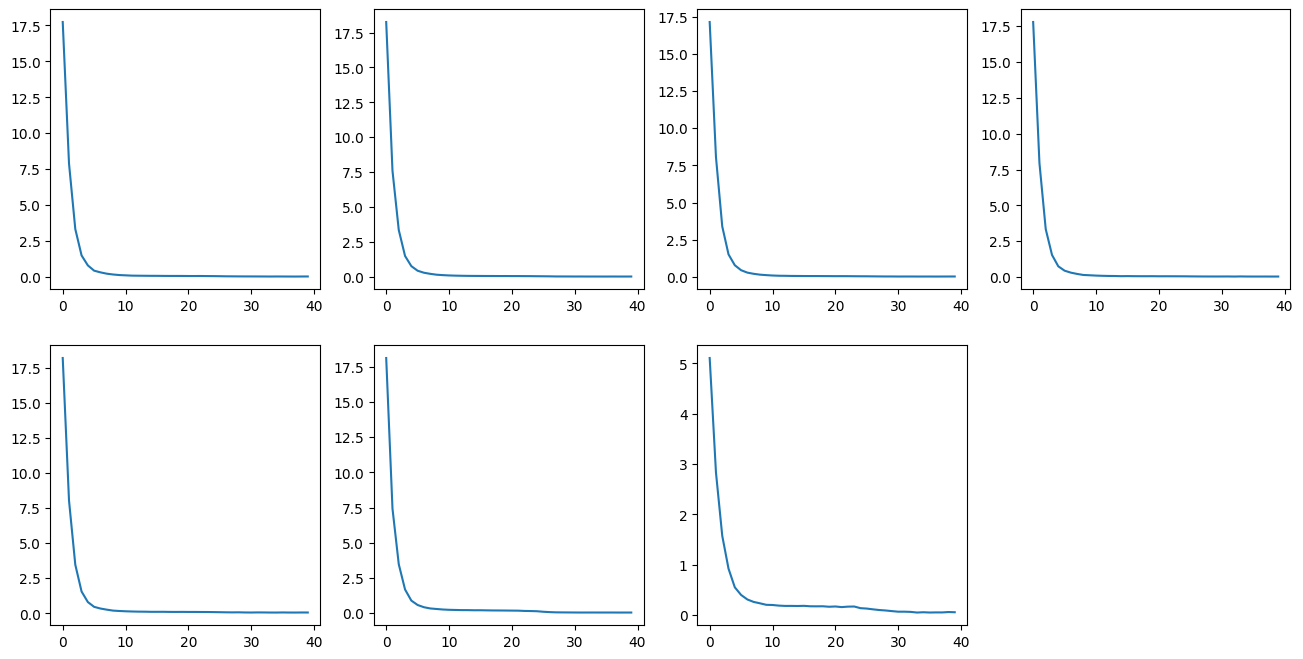

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, d in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][d])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.06086106263101101, 0.6940143812447787)

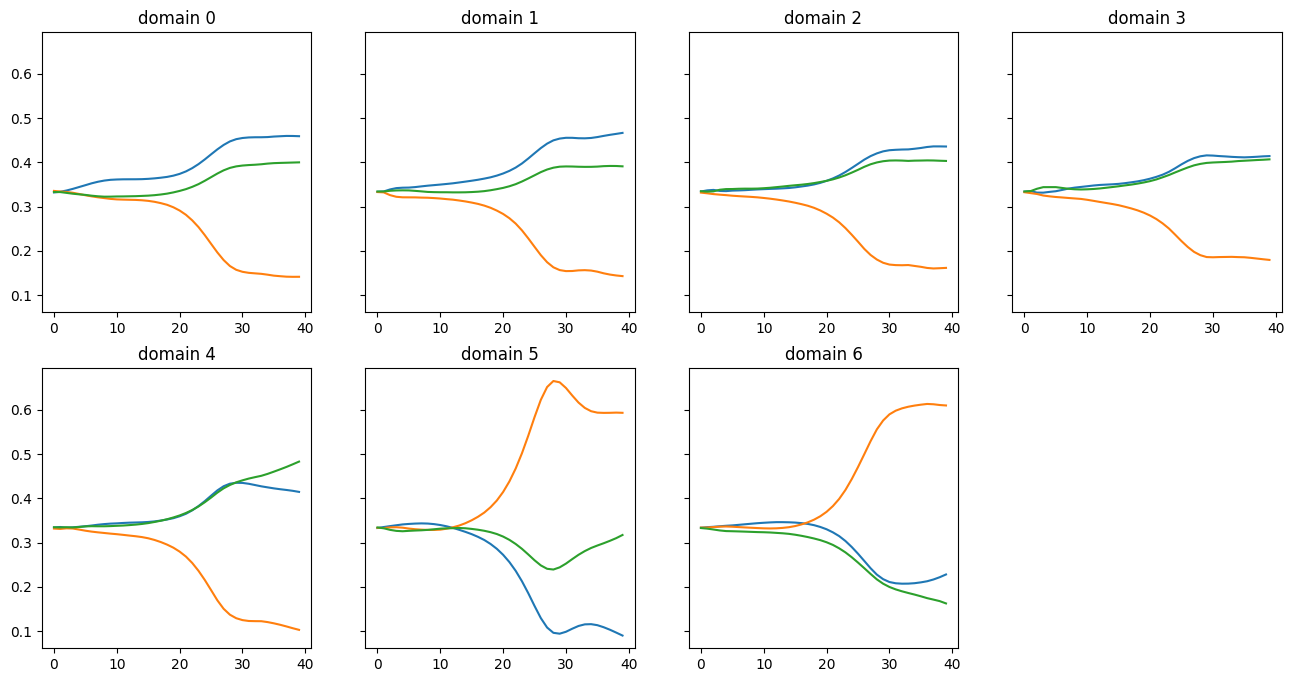

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [21]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2278, 0.6099, 0.1623])


In [22]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [23]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


In [24]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6384615384615384
